In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from eecs598.utils import reset_seed
from collections import OrderedDict

import torchvision.models as models
from torchviz import make_dot

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from pytorch_autograd_and_nn import *
from a4_helper import *
hello()

%load_ext autoreload
%autoreload 2

Hello from pytorch_autograd_and_nn.py!


## 01 - loading CIFAR-10

Looks like we work with the full CIFAR-10 dataset: 50K training and 10K test examples. From training examples we get 1K validation examples. We're going to get ~80% using `resnet` that is much better than ~50% that we get from a simple 3-layer net.

In [2]:
to_float= torch.float
to_long = torch.long

loader_train, loader_val, loader_test = load_CIFAR(path='./datasets/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(loader_train), type(loader_train), len(loader_val)

(766, torch.utils.data.dataloader.DataLoader, 16)

In [4]:
x, y = next(iter(loader_train))

In [5]:
x.shape, y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [6]:
766 * 64, 16 * 64

(49024, 1024)

In [7]:
x[0].permute(1, 2, 0)[0, 0, :]

tensor([ 0.6144, -0.0582, -0.4460])

## 02 - resnet (standard)

Let's start with a standard version of `resnet-34`. 

Why is it 34? It contains 34 layers with weights (see fig. 3; all links to the 2 papers): 1) `7x7` convolution; 2) 32 convolution layer in blocks and 3) softmax layer. We don't count residual connections.

What are the main principles behind `resnet`. Well here they are:
- aggressive downsampling in the beginning - `7x7` convolution;
- repeated blocks with only `3x3` convolution and increasing depth; depth is in fact increasing from 64 to 512;
- average pooling instead of fully connected layers in the end;

### overall structure

Let's try to look inside this net. We may see that:
- the first layer with weights is in fact `7x7` convolution (`conv1` in table 1);
- then we have 4 blocks called `layer1` - `layer4` (`conv2` - `conv5` in table 1);
- finally we have average pooling;

In [8]:
resnet34 = models.resnet34()

In [9]:
modules = list(resnet34.modules())

In [10]:
type(modules), len(modules)

(list, 116)

In [11]:
modules[0]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
modules[1:5]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

### basic blocks

Let's check the number of `BasicBlocks` in each layer. As we may see the number of blocks is exactly the same as we have in table 1.

In [13]:
def get_number_basic_blocks():
    
    layers = ['layer1', 'layer2', 'layer3', 'layer4']
    
    # get layer1 - layer4 blocks
    modules_layer = {}
    for name, module in resnet34.named_modules():
        if name in layers:
            modules_layer[name] = module
            
    block_names = [str(i) for i in list(range(10))]   
    block_count = dict(zip(layers, [0] * len(layers)))
    for layer in layers:
        for name, _ in modules_layer[layer].named_modules():
            if name in block_names:
                block_count[layer] += 1
                
    return block_count

In [14]:
get_number_basic_blocks()

{'layer1': 3, 'layer2': 4, 'layer3': 6, 'layer4': 3}

We can check this directly for the `layer1` for example. We may also see that `BasicBlock` contains 2 convolution layers.

In [15]:
modules[5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

### convolution layers

Let's also count convolution layers. As expected we get 33 layers: 32 in blocks and 1 layer in the beginning.

In [16]:
def get_number_conv_layers():
    conv_count = 0
    for name, module in resnet34.named_modules():
        if 'conv' in name:
            conv_count += 1
    return conv_count

In [17]:
get_number_conv_layers()

33

### other questions

We have 3 questions left:
- what does downsampling mean?
- where are all skip connections?
- how does average pooling work?

### skip connections

Where are those skip connections? It seems they are not visible when we just print out the model.

In [18]:
import torchvision.models
import hiddenlayer as hl

/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


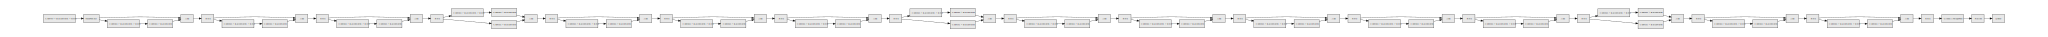

In [21]:
hl.build_graph(resnet34, torch.zeros([1, 3, 224, 224]))

### downsampling

### average pooling

In [27]:
named_modules = dict(resnet34.named_modules())

In [38]:
list(named_modules.keys())[5:25]

['layer1',
 'layer1.0',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer2']

In [40]:
named_modules['layer1.0']

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)